## requirements.txt

In [1]:
# !pip freeze > requirements.txt
!pip install -r requirements.txt

## Загрузка библиотек и зависимостей

In [2]:
import time
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import catboost
from catboost import Pool, CatBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tsfresh as tsf
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series

In [4]:
# Imbalanced Dependencies
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

## Загрузка данных

In [5]:
df_train = pd.read_parquet("DCS/Train/hackaton2023_train.gzip")
df_test = pd.read_parquet("DCS/Test/hackaton2023_test.gzip")

df_train.shape, df_test.shape

((12129384, 9), (2498034, 7))

|     Название                |     Описание                                                                             |     Тип   переменной    |     Комментарий                |   |
|-----------------------------|------------------------------------------------------------------------------------------|-------------------------|--------------------------------|---|
|     customer_id             |     Идентификатор   клиента                                                              |     int                 |                                |   |
|     group_name              |     Группа:   train (обучение) – test(контроль)                                          |                         |                                |   |
|     revenue                 |     Выручка   от продажи блюда в заказе                                                  |     float               |                                |   |
|     startdatetime           |     Дата   и время продажи                                                               |     datetime            |                                |   |
|     dish_name               |     Название   блюда                                                                     |     string              |                                |   |
|     ownareaall_sqm          |     Площадь   ресторана                                                                  |     float               |                                |   |
|     format_name             |     Формат   ресторана                                                                   |                         |                                |   |
|     buy_post                |     Таргет   1: флаг оттока     (0 – отток, 1 – не отток)                                |     bool                |     Только   в train данных    |   |
|     date_diff_post          |     Таргет   2: количество дней между последней покупкой в прошлом и первой в будущем    |     int                 |     Только   в train данных    |   |

In [6]:
df_train.head(7)

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны
5,29891,9.0,1,train,60.00,2022-12-15 00:37:19,Чизбургер,463.0,Отдельно стоящий с внешней зоной
6,29891,9.0,1,train,209.99,2022-12-15 00:37:19,Воппер Ролл,463.0,Отдельно стоящий с внешней зоной


## EDA

In [7]:
# Распределение таргета
target_d = pd.DataFrame(df_train['buy_post'].value_counts())
target_d

,count
buy_post,
1,9660867
0,2468517


In [8]:
# Проверка на новых пользователей в тестовой выборке
train_customers = set(df_train['customer_id'].unique().tolist())
test_customers = set(df_test['customer_id'].unique().tolist())

assert len(train_customers - test_customers) == len(train_customers), "Клиенты в трейне не повторяются!"
assert len(test_customers - train_customers) == len(test_customers), "Клиенты в тесте не повторяются!"

# Делаем вывод, что для валидации нужно брать клиентов не из обучающей выборке

## Минимальная обработка данных

In [9]:
# Объединяем данные
data = pd.concat([df_train, df_test])

In [10]:
# Сортируем по ID клиента и по дате транзакции
data = data.sort_values(by=['customer_id', 'startdatetime'], ascending=True)

```
# Сохранение данных в локальную базу данных
encoder = LabelEncoder()
data['encode_format_name'] = encoder.fit_transform(data['format_name'])
data['encode_dish_name'] = encoder.fit_transform(data['dish_name'])

data['is_test'] = data['group_name'].map({'train': 0, 'test': 1})
data = data.drop(columns=['group_name'])

format_name = data[['encode_format_name', 'format_name']].drop_duplicates().to_parquet("format_name.parquet", index=False)
dish_name = data[['encode_dish_name', 'dish_name']].drop_duplicates().to_parquet("dish_name.parquet", index=False)
data = data.drop(columns=['format_name', 'dish_name'])

data.to_parquet("data.parquet", index=False)

In [11]:
# --- Собираем строки в заказы

# Группируем по колонкам и генерируем минимальные фичи
agg_features = {
    'date_diff_post': 'last',
    'buy_post': 'last',
    'group_name': 'last',
    'revenue': 'sum',
    'ownareaall_sqm': 'last',
    'format_name': 'last'
}
data = data.groupby(["customer_id", "startdatetime"], as_index=False).agg(agg_features)

In [12]:
# Приводим таргеты к целочисленным форматам
data['buy_post'] = data['buy_post'].astype('Int64')
data['date_diff_post'] = data['date_diff_post'].astype('Int64')

In [13]:
# Разделяем данные на обучающие и тестовые
df_train = data[data['group_name'] == "train"]
df_test = data[data['group_name'] == "test"]

In [14]:
# Создаем обучающую выборку, убирая последние строки (делаем таргеты в качестве последней транзакции)
y_train = df_train.groupby('customer_id').tail(1)
y_train = y_train[['customer_id', 'buy_post']]
y_train['churn'] = y_train['buy_post']
y_train = y_train.drop(columns=['buy_post'])

df_train = df_train.drop(list(y_train.index))

In [15]:
# --- Baseline Features

# Считаем признаки через агрегации 
agg_features = {
    # 'date_diff_post': ['last', 'mean', 'min', 'max', 'std'],
    # 'buy_post': ['last', 'mean', 'min', 'max', 'std'],
    # 'group_name': 'last',
    'revenue': ['mean', 'min', 'max', 'std'],
    'ownareaall_sqm': ['mean', 'min', 'max', 'std'],
    'format_name': 'last',
}
df_train = df_train.groupby('customer_id', as_index=False).agg(agg_features)

# Переименовываем колонки в удобный формат
new_columns = [col[0] + "_" + col[1] for col in df_train.columns[1:]]
df_train.columns = ['customer_id'] + new_columns

In [16]:
df_train = df_train.merge(y_train, how='left', on='customer_id')

## Custom Train-Test Split

In [17]:
def split_by_client(df, test_size=0.5):
    """
        Метод разделения трейн теста, таким образом чтобы одинаковые клиенты не попадали в разные наборы
        и при этом сохранилась стратификация по данным
    """
    clients_target_1 = df[df["churn"] == 1]["customer_id"].unique()
    clients_t1_train, clients_t1_test = train_test_split(clients_target_1, test_size=test_size, shuffle=True, random_state=53)
    
    clients_target_0 = df[df["churn"] == 0]["customer_id"].unique()
    clients_t0_train, clients_t0_test = train_test_split(clients_target_0, test_size=test_size, shuffle=True, random_state=53)
    
    clients_t0_train = list(set(clients_t0_train) - set(clients_t1_test))
    clients_t0_test = list(set(clients_t0_test) - set(clients_t1_train))
    
    train = pd.concat([df[(df['customer_id'].isin(clients_t0_train))], df[(df['customer_id'].isin(clients_t1_train))] ] )
    test = pd.concat([df[(df['customer_id'].isin(clients_t0_test))], df[(df['customer_id'].isin(clients_t1_test))]])
    
    # train = train.drop_duplicates(subset=["report_date", "customer_id"])
    # test = test.drop_duplicates(subset=["report_date", "customer_id"])
    
    return train, test

In [18]:
train_data, val_data = split_by_client(df_train, test_size=0.2)
val_data, test_data = split_by_client(val_data, test_size=0.5)

# Проверяем, что нет лика данных по клиентам между трайн/вал/тест
assert len(set(train_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик train val"
assert len(set(train_data["customer_id"]) & set(test_data["customer_id"])) == 0, "Лик train test"
assert len(set(test_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик test val"

train_data.shape, test_data.shape, val_data.shape

((400000, 11), (50001, 11), (49999, 11))

In [19]:
# Проверяем дисбаланс разбиения train/val/test
train_data["churn"].value_counts(), val_data["churn"].value_counts(), test_data["churn"].value_counts()

(churn
 1    287276
 0    112724
 Name: count, dtype: Int64,
 churn
 1    35909
 0    14090
 Name: count, dtype: Int64,
 churn
 1    35910
 0    14091
 Name: count, dtype: Int64)

In [20]:
train_data.dtypes

customer_id              int64
revenue_mean           float64
revenue_min            float64
revenue_max            float64
revenue_std            float64
ownareaall_sqm_mean    float64
ownareaall_sqm_min     float64
ownareaall_sqm_max     float64
ownareaall_sqm_std     float64
format_name_last        object
churn                    Int64
dtype: object

In [21]:
feature_columns = ['revenue_mean', 'revenue_min', 'revenue_max', 'revenue_std', 
                   'ownareaall_sqm_mean', 'ownareaall_sqm_min', 'ownareaall_sqm_max',
                   'ownareaall_sqm_std', 'format_name_last']
target_column = ['churn']
cat_columns = ['format_name_last']
id_column = ['customer_id']

In [22]:
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_val = val_data[feature_columns]
y_val = val_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

((400000, 9), (400000, 1), (49999, 9), (49999, 1), (50001, 1), (50001, 9))

## Кастомные вспомогательные функции

In [23]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc


In [24]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """
        Функция вывода feature importance
            :importance - массив важности фичей, полученный от модели
            :names - массив названий фичей
            :model_name - название модели
            :top_n - кол-во выводимых фичей
            :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                            из отображаемых горячие фичи, и изучить менее сильные
            :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df


# Baseline

## CatBoost | Отток пользователей (Бинарная классификация)

In [25]:
# Расчет дисбалнса классов
tdist = y_train['churn'].value_counts()
class_weights = {0: tdist[1] / tdist[0], 1: tdist[0] / tdist[1]}

class_weights

{0: 2.5484901174550227, 1: 0.3923892006293599}

In [26]:
model = CatBoostClassifier(
    eval_metric="F1",
    iterations=500,
    early_stopping_rounds=50, 
    class_weights=class_weights, 
    cat_features=cat_columns, 
    random_state=53
)
model.fit(
    X_train, 
    y_train, 
    eval_set=(X_val, y_val), 
    plot=True, verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

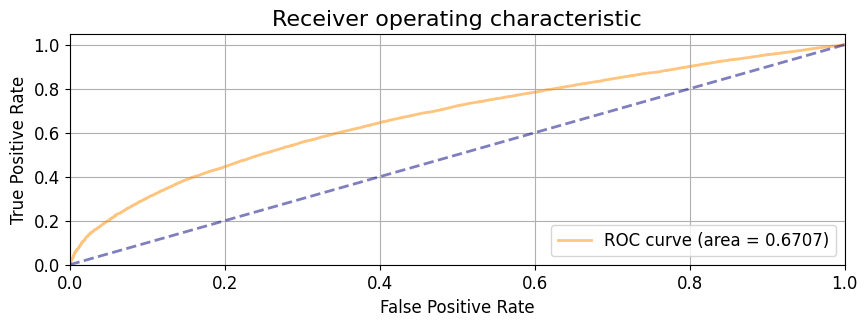

ROC-AUC Score:  0.6706999482873595
              precision    recall  f1-score   support

         0.0       0.32      0.95      0.48     14091
         1.0       0.91      0.21      0.34     35910

    accuracy                           0.42     50001
   macro avg       0.61      0.58      0.41     50001
weighted avg       0.74      0.42      0.38     50001

F1 Score:  0.34075582711020597


In [28]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_proba)
print("ROC-AUC Score: ", roc_auc)
print(classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

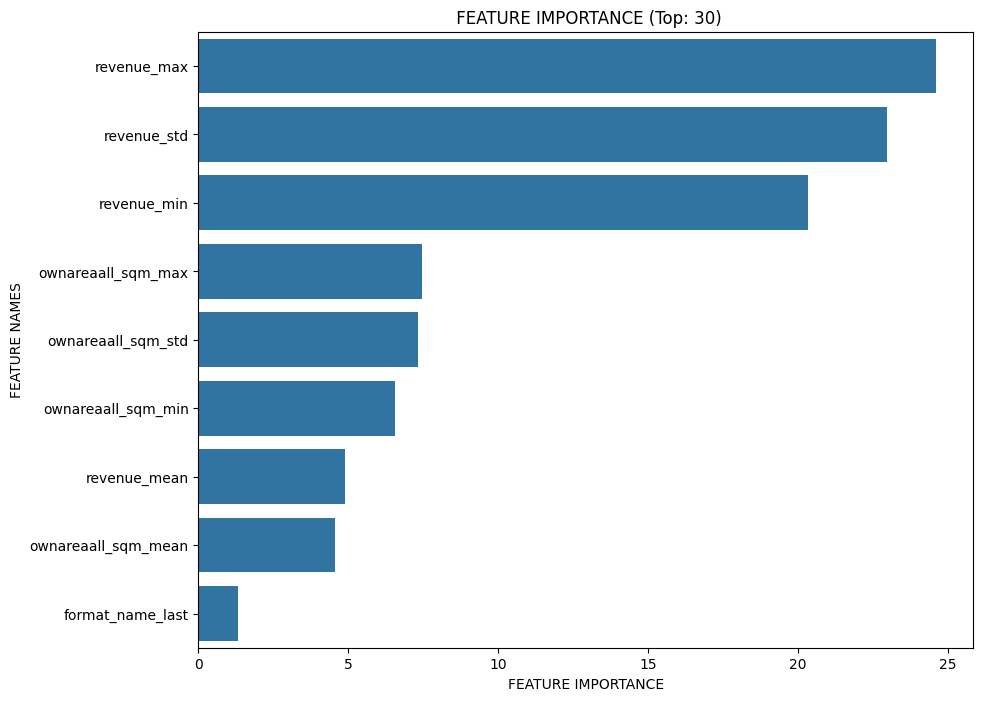

In [29]:
# Построение важности признаков
dfi = plot_feature_importance(model.get_feature_importance(), X_test.columns, top_n=30) 